# Bike-sharing Data Regression Assignment

Building a ML model for the prediction of demand for shared bikes

Steps we will follow in this exercise

    1. Reading and Understand the Data
    2. Visualize the data
    3. Preparing the data for modelling (train-test split, rescaling etc.,)
    4. Training the model
    5. Residual Analysis
    6. Predictions of test data
    7. Model Evaluation

## Step 1 - Read and Understand the Data

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import statsmodels
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings('ignore')

In [2]:
# read the data from file
bikes = pd.read_csv('day.csv')
bikes.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [3]:
# checking dataset for any null values
bikes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


In [4]:
# checking the statistics of numerical columns
bikes.describe()

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000
mean,365.500000,2.498630,0.500000,6.526027,0.028767,2.997260,0.683562,1.394521,20.319259,23.726322,62.765175,12.763620,849.249315,3658.757534,4508.006849
std,210.877136,1.110184,0.500343,3.450215,0.167266,2.006161,0.465405,0.544807,7.506729,8.150308,14.237589,5.195841,686.479875,1559.758728,1936.011647
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,2.424346,3.953480,0.000000,1.500244,2.000000,20.000000,22.000000
25%,183.250000,2.000000,0.000000,4.000000,0.000000,1.000000,0.000000,1.000000,13.811885,16.889713,52.000000,9.041650,316.250000,2502.250000,3169.750000
50%,365.500000,3.000000,0.500000,7.000000,0.000000,3.000000,1.000000,1.000000,20.465826,24.368225,62.625000,12.125325,717.000000,3664.500000,4548.500000
75%,547.750000,3.000000,1.000000,10.000000,0.000000,5.000000,1.000000,2.000000,26.880615,30.445775,72.989575,15.625589,1096.500000,4783.250000,5966.000000
max,730.000000,4.000000,1.000000,12.000000,1.000000,6.000000,1.000000,3.000000,35.328347,42.044800,97.250000,34.000021,3410.000000,6946.000000,8714.000000


In [5]:
# To list out the count of unique values for each column
bikes.nunique()

instant       730
dteday        730
season          4
yr              2
mnth           12
holiday         2
weekday         7
workingday      2
weathersit      3
temp          498
atemp         689
hum           594
windspeed     649
casual        605
registered    678
cnt           695
dtype: int64

### - Observations:

- Most <B>categorical variables</B> are categorized using numerical values. They are
    - season, yr, mnth, holiday, weekday, workingday, weathersit
    
- <B>'instant' column</B> is the serial number of the data
    - <i>This needs to be removed</i>
    
- The entire data set is collected only for 2018 and 2019 years

- <B>'dteday'</B> is the date column, however we have month and year defined in separate columns 'mnth' and 'yr'

#### Notes:

- <B>'Casual' and 'Registered' columns</B> are actually part of 'cnt' (total count)
    - This means the final value of 'cnt' is already covered in these both variables
    - Casual and Registered counts can also be predicted (Y) individually to identify what variables are influencing their individual counts.
- Having these Casual and Registered as predictor variables in the model, results in <b> 1.00 as R-squared value and Adjusted R-squared value</b> <i>(tested separately)</i>, which is too perfect fit for a model.
- Hence, these variables has to be dropped

### Drop Instant, Casual, Registered variables

In [6]:
bikes = bikes.drop(['instant', 'casual', 'registered'], axis=1)
bikes.head()

,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,985
1,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,801
2,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,1349
3,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,1562
4,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,1600


## Step 2 - Visualize the Data

- Before plotting graphs using the data, let us do some changes in the data set
- Replace numeric categories with proper string values

### Replace Categorical numeric scale with proper string values
- To use categories to define categorical data instead of numerical scale
- season : (1:spring, 2:summer, 3:fall, 4:winter)
- Weekday: 1-7 => Sunday to Saturday
- Months : 1-12 months => January to December
- Weathersit: 
    - w1    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
	- w2	- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
	- w3	- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
	- w4	- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog

In [7]:
# replace numeric values of categorical vars with categories
# [yr, holiday, weekday columns] are not converted as they have only 2 categories
# define category lists
seasons = ['spring','summer','fall','winter']
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
weekdays = ['Sun', 'Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat']
weatherSituation = ['w1','w2','w3','w4']

In [8]:
# Apply category definitions on dataset to replace number scale with proper meaning data
bikes['season'] = bikes['season'].apply(lambda i: seasons[i-1])
bikes['mnth'] = bikes['mnth'].apply(lambda i: months[i-1])
bikes['weekday'] = bikes['weekday'].apply(lambda i: weekdays[i-1])
bikes['weathersit'] = bikes['weathersit'].apply(lambda i: weatherSituation[i-1])

In [9]:
bikes.head()

,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,01-01-2018,spring,0,Jan,0,Fri,0,w2,14.110847,18.18125,80.5833,10.749882,985
1,02-01-2018,spring,0,Jan,0,Sat,0,w2,14.902598,17.68695,69.6087,16.652113,801
2,03-01-2018,spring,0,Jan,0,Sun,1,w1,8.050924,9.47025,43.7273,16.636703,1349
3,04-01-2018,spring,0,Jan,0,Mon,1,w1,8.200000,10.60610,59.0435,10.739832,1562
4,05-01-2018,spring,0,Jan,0,Tues,1,w1,9.305237,11.46350,43.6957,12.522300,1600


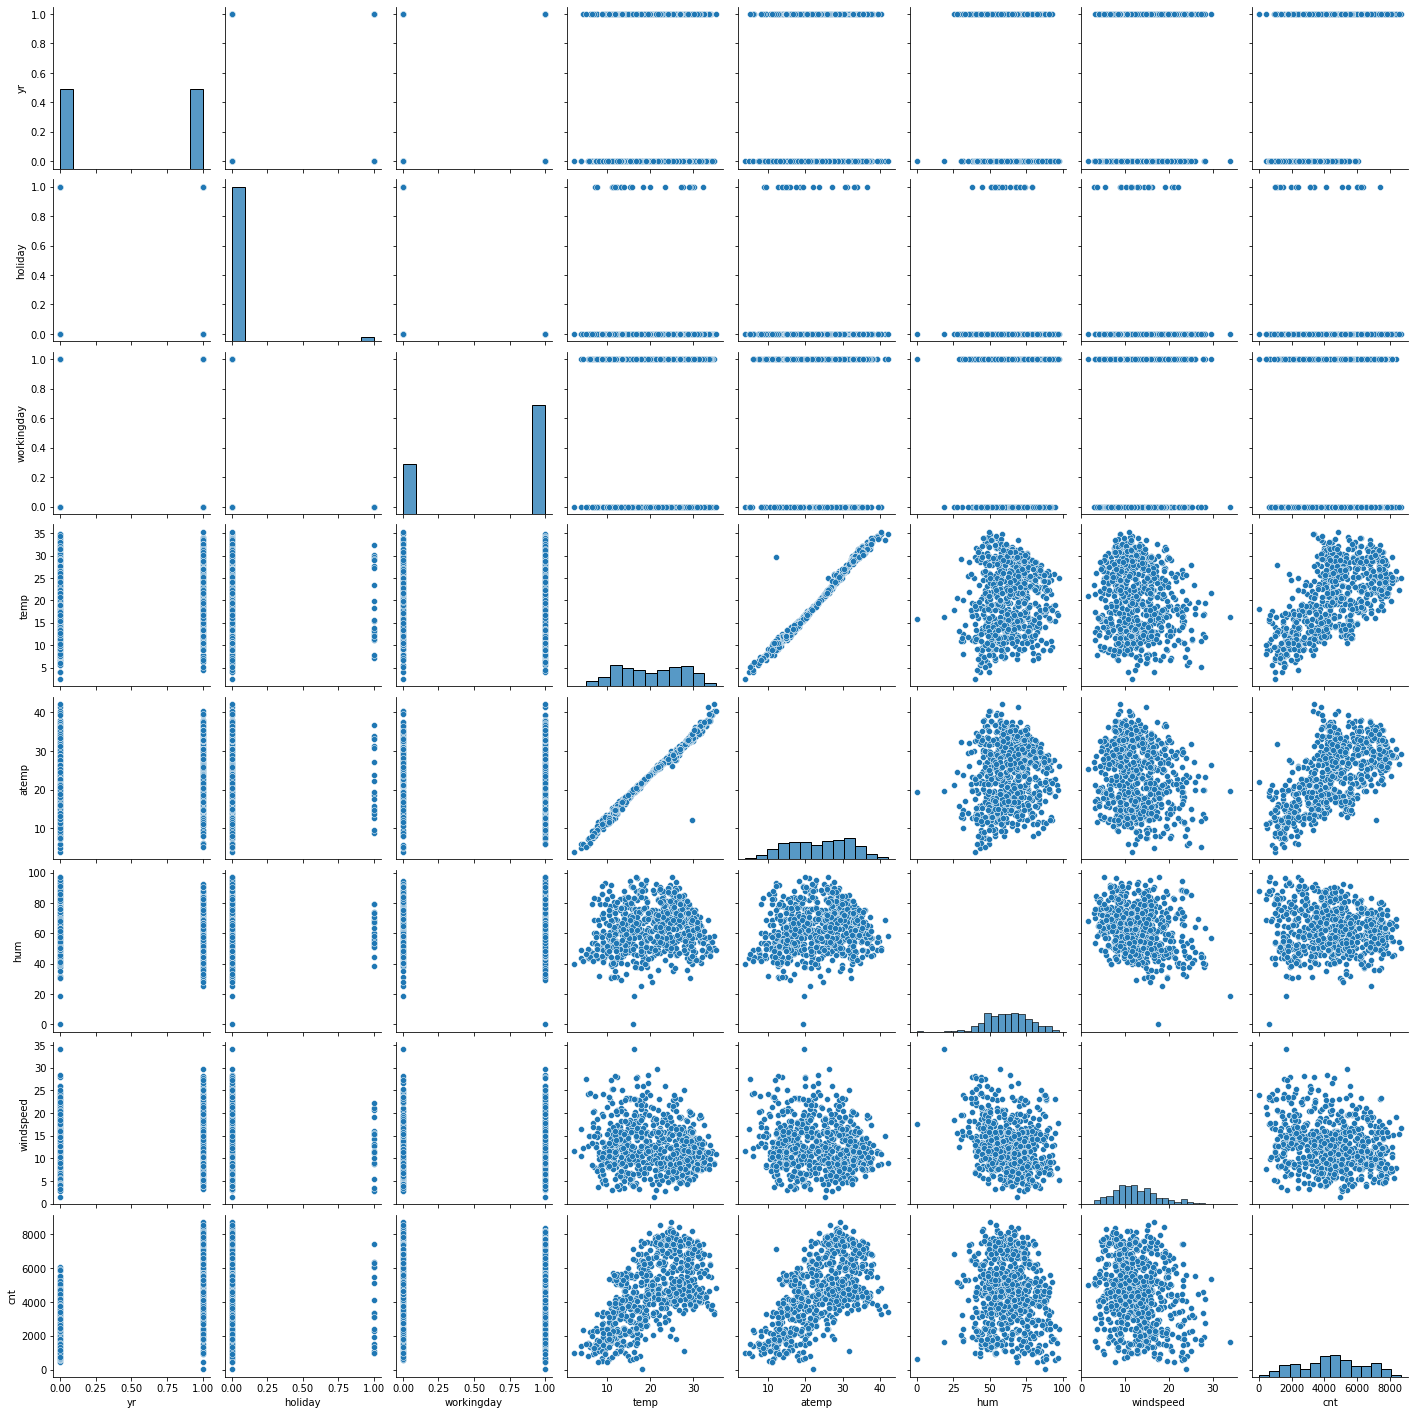

In [10]:
# Plotting the pairplot to check any relationship exists b/w vars
sns.pairplot(bikes)
plt.show()

#### Visulaize Numeric variables

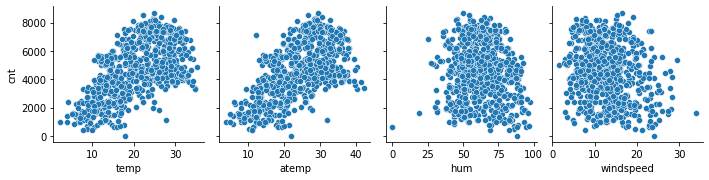

In [11]:
# Plotting the numerical variables in separate 
sns.pairplot(x_vars=['temp','atemp', 'hum','windspeed'], 
             y_vars='cnt', 
             data=bikes)
plt.show()

#### Observations:

- Many of categorical vars are defined with numerical values in data set, So many graphs are shown in pairplots
- However, We can see some linear relationship of count with temp, atemp, casual, registered columns.
- To get better understanding of numerical variables, we have to plot graphs with numeric, categorical vars separately

### Visualize categorical variables

<AxesSubplot:xlabel='weathersit', ylabel='cnt'>

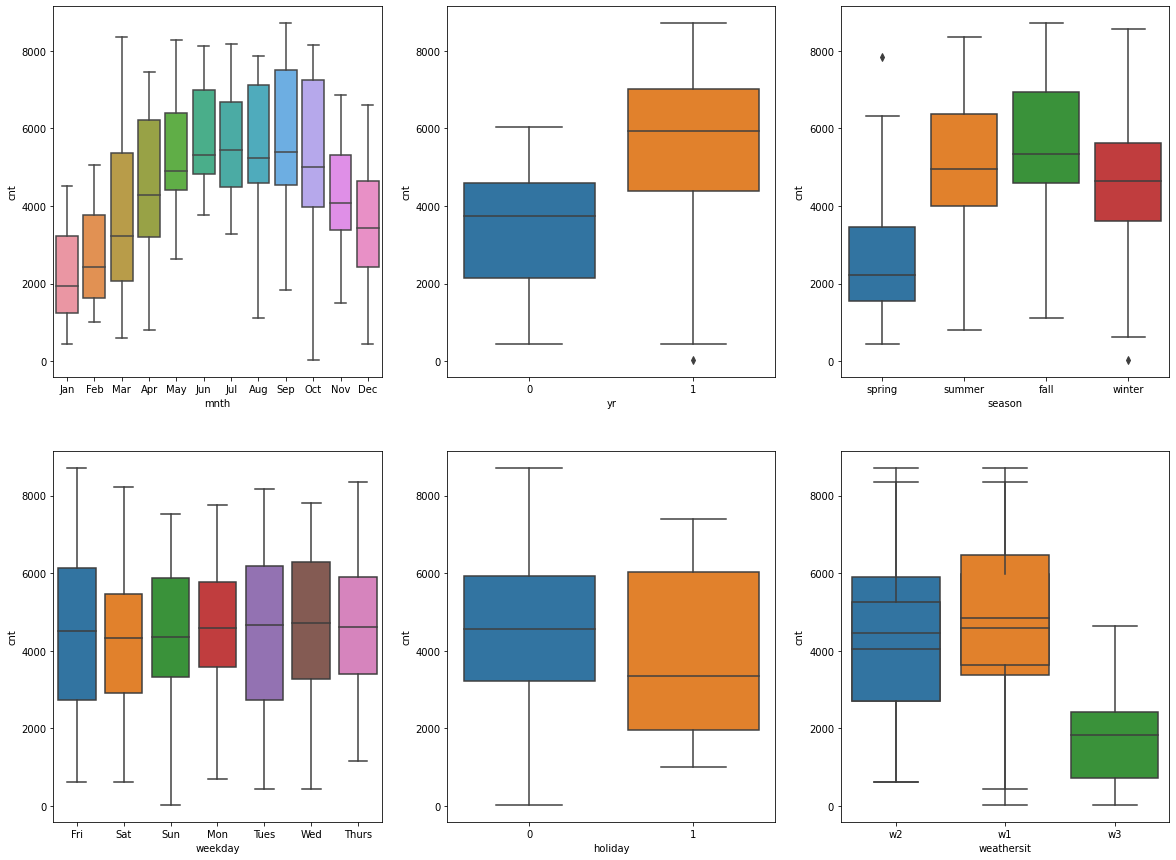

In [12]:
# Visualize all the categorical data
plt.figure(figsize=(20, 15))
plt.subplot(2, 3, 1)
sns.boxplot(x='mnth', y='cnt', data=bikes)
plt.subplot(2, 3, 2)
sns.boxplot(x='yr', y='cnt', data=bikes)
plt.subplot(2, 3, 3)
sns.boxplot(x='season', y='cnt', data=bikes)
plt.subplot(2, 3, 4)
sns.boxplot(x='weekday', y='cnt', data=bikes)
plt.subplot(2, 3, 5)
sns.boxplot(x='holiday', y='cnt', data=bikes)
plt.subplot(2, 3, 6)
sns.boxplot(x='workingday', y='cnt', data=bikes)
plt.subplot(2, 3, 6)
sns.boxplot(x='weathersit', y='cnt', data=bikes)

### Observations:

1. For 'mnth' var, there is a visible pattern with increase in cnt in the months from May to October
2. We can see a huge difference in the mean count for year variable, showing significant increase in count from 2018 to 2019.
3. Season variable is also showing some difference in count with respect to change in season.
4. There is no difference in the average count of bikes with respect to weekdays
5. The median of non holiday count is higher than that of holiday's
6. There is significant difference in the cnt for weather situation w3 (which is storm or light rain or snow).

## Step 3 - Prepare the data for Modelling

In [13]:
bikes.columns

Index(['dteday', 'season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday',
       'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'cnt'],
      dtype='object')

In [14]:
bikes.head()

,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,01-01-2018,spring,0,Jan,0,Fri,0,w2,14.110847,18.18125,80.5833,10.749882,985
1,02-01-2018,spring,0,Jan,0,Sat,0,w2,14.902598,17.68695,69.6087,16.652113,801
2,03-01-2018,spring,0,Jan,0,Sun,1,w1,8.050924,9.47025,43.7273,16.636703,1349
3,04-01-2018,spring,0,Jan,0,Mon,1,w1,8.200000,10.60610,59.0435,10.739832,1562
4,05-01-2018,spring,0,Jan,0,Tues,1,w1,9.305237,11.46350,43.6957,12.522300,1600


### Data Cleaning

#### 1. Apply Dummy variables for categorical variables

- Season Column has 4 unique type, which require 3 dummy variables
- Similarly, mnth, weekday and weathersit columns require dummy variables
- By default dropping the extra dummy variable
    - For ex, if spring =0, summer =0, winter = 0, fall=1 then season is fall
    - if spring =0, summer=0, winter=0 then also season is fall.

In [15]:
# Dummy variables for season column
seasonStatus = pd.get_dummies(bikes['season'], drop_first=True)
seasonStatus.head()

,spring,summer,winter
0,1,0,0
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0


In [16]:
# Dummy variables for other categorical columns
mnthStatus = pd.get_dummies(bikes['mnth'], drop_first=True)
weekStatus = pd.get_dummies(bikes['weekday'], drop_first=True)
weatherStatus = pd.get_dummies(bikes['weathersit'], drop_first=True)

In [17]:
# concatenate dummy vars to bikes dataset
bikes = pd.concat([bikes, seasonStatus, mnthStatus, weekStatus, weatherStatus], axis=1)
bikes.head()

,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,...,Oct,Sep,Mon,Sat,Sun,Thurs,Tues,Wed,w2,w3
0,01-01-2018,spring,0,Jan,0,Fri,0,w2,14.110847,18.18125,...,0,0,0,0,0,0,0,0,1,0
1,02-01-2018,spring,0,Jan,0,Sat,0,w2,14.902598,17.68695,...,0,0,0,1,0,0,0,0,1,0
2,03-01-2018,spring,0,Jan,0,Sun,1,w1,8.050924,9.47025,...,0,0,0,0,1,0,0,0,0,0
3,04-01-2018,spring,0,Jan,0,Mon,1,w1,8.200000,10.60610,...,0,0,1,0,0,0,0,0,0,0
4,05-01-2018,spring,0,Jan,0,Tues,1,w1,9.305237,11.46350,...,0,0,0,0,0,0,1,0,0,0


#### Formatting the date object

- month and year of bikes set are already provided as separate columns ['mnth', 'yr'] in dataset.
- The idea of using the dates within month seems not feasible, As all the dates might also be covered by other variables
- However, considering the variable to see if there is any significance on monthly dates (Like hike in start of month, end of the month etc.,.)

In [18]:
# We have dteday - Date variable which needs addressing
# Convert Object 'dteday' to Date Format
bikes.dteday = bikes.dteday.apply(pd.to_datetime)

# lets get only day from the Date, as we dont need month and year
bikes['dteday'] = [d.day for d in bikes['dteday']]
bikes.head()

,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,...,Oct,Sep,Mon,Sat,Sun,Thurs,Tues,Wed,w2,w3
0,1,spring,0,Jan,0,Fri,0,w2,14.110847,18.18125,...,0,0,0,0,0,0,0,0,1,0
1,1,spring,0,Jan,0,Sat,0,w2,14.902598,17.68695,...,0,0,0,1,0,0,0,0,1,0
2,1,spring,0,Jan,0,Sun,1,w1,8.050924,9.47025,...,0,0,0,0,1,0,0,0,0,0
3,1,spring,0,Jan,0,Mon,1,w1,8.200000,10.60610,...,0,0,1,0,0,0,0,0,0,0
4,1,spring,0,Jan,0,Tues,1,w1,9.305237,11.46350,...,0,0,0,0,0,0,1,0,0,0


In [19]:
# dteday is now a finite variable of 31 days
# let us use dummy variable to scale dteday column
day = pd.get_dummies(bikes['dteday'], drop_first=True)

# concatenate dummy vars to bikes dataset
bikes = pd.concat([bikes, day], axis=1)
bikes.head()

,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,...,22,23,24,25,26,27,28,29,30,31
0,1,spring,0,Jan,0,Fri,0,w2,14.110847,18.18125,...,0,0,0,0,0,0,0,0,0,0
1,1,spring,0,Jan,0,Sat,0,w2,14.902598,17.68695,...,0,0,0,0,0,0,0,0,0,0
2,1,spring,0,Jan,0,Sun,1,w1,8.050924,9.47025,...,0,0,0,0,0,0,0,0,0,0
3,1,spring,0,Jan,0,Mon,1,w1,8.200000,10.60610,...,0,0,0,0,0,0,0,0,0,0
4,1,spring,0,Jan,0,Tues,1,w1,9.305237,11.46350,...,0,0,0,0,0,0,0,0,0,0


In [20]:
bikes.shape

(730, 65)

In [21]:
bikes.columns

Index([    'dteday',     'season',         'yr',       'mnth',    'holiday',
          'weekday', 'workingday', 'weathersit',       'temp',      'atemp',
              'hum',  'windspeed',        'cnt',     'spring',     'summer',
           'winter',        'Aug',        'Dec',        'Feb',        'Jan',
              'Jul',        'Jun',        'Mar',        'May',        'Nov',
              'Oct',        'Sep',        'Mon',        'Sat',        'Sun',
            'Thurs',       'Tues',        'Wed',         'w2',         'w3',
                  2,            3,            4,            5,            6,
                  7,            8,            9,           10,           11,
                 12,           13,           14,           15,           16,
                 17,           18,           19,           20,           21,
                 22,           23,           24,           25,           26,
                 27,           28,           29,           30,           31]

In [22]:
# dropping the original category columns of dummy variables from dataset
bikes = bikes.drop(['season', 'weekday', 'mnth', 'weathersit', 'dteday'], axis=1)
bikes.head()

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,spring,summer,...,22,23,24,25,26,27,28,29,30,31
0,0,0,0,14.110847,18.18125,80.5833,10.749882,985,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,14.902598,17.68695,69.6087,16.652113,801,1,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,8.050924,9.47025,43.7273,16.636703,1349,1,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,1,8.200000,10.60610,59.0435,10.739832,1562,1,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,1,9.305237,11.46350,43.6957,12.522300,1600,1,0,...,0,0,0,0,0,0,0,0,0,0


### Splitting the Dataset

- Split data into train and test sets

In [23]:
# splitting teh data to train and test dataset
df_train, df_test = train_test_split(bikes, train_size=0.7, random_state=100)
print(df_train.shape)
print(df_test.shape)

(510, 60)
(220, 60)


### Data Sclaing

- All the categorical variables are with in the scale of '0' and '1'
- Scaling Numerical data as well using Normalization method
    - Scale the values between 0 and 1

In [24]:
# Data scaling using MinMaxScale

scaler = MinMaxScaler()
num_vars = ['temp','atemp','hum','windspeed','cnt']
df_train[num_vars] = scaler.fit_transform(df_train[num_vars])

df_train.head()

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,spring,summer,...,22,23,24,25,26,27,28,29,30,31
576,1,0,1,0.815169,0.766351,0.725633,0.264686,0.827658,0,0,...,0,0,0,0,0,0,0,0,0,1
426,1,0,0,0.442393,0.438975,0.640189,0.255342,0.465255,1,0,...,0,0,0,0,0,0,0,0,0,0
728,1,0,0,0.245101,0.200348,0.498067,0.663106,0.204096,1,0,...,0,0,0,0,0,0,0,0,1,0
482,1,0,0,0.395666,0.391735,0.504508,0.188475,0.482973,0,1,...,0,0,0,0,0,0,1,0,0,0
111,0,0,1,0.345824,0.318819,0.751824,0.380981,0.191095,0,1,...,1,0,0,0,0,0,0,0,0,0


In [25]:
df_train.describe()

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,spring,summer,...,22,23,24,25,26,27,28,29,30,31
count,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,...,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000
mean,0.507843,0.025490,0.676471,0.537440,0.513156,0.650480,0.320883,0.513499,0.243137,0.247059,...,0.039216,0.025490,0.037255,0.027451,0.031373,0.029412,0.031373,0.035294,0.029412,0.017647
std,0.500429,0.157763,0.468282,0.225858,0.212410,0.145846,0.169803,0.224421,0.429398,0.431725,...,0.194298,0.157763,0.189572,0.163554,0.174494,0.169124,0.174494,0.184703,0.169124,0.131794
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.339853,0.332086,0.538643,0.199179,0.356420,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,1.000000,0.542596,0.529718,0.653714,0.296763,0.518638,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,0.735215,0.688457,0.754830,0.414447,0.684710,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Step 4 - Training the Model

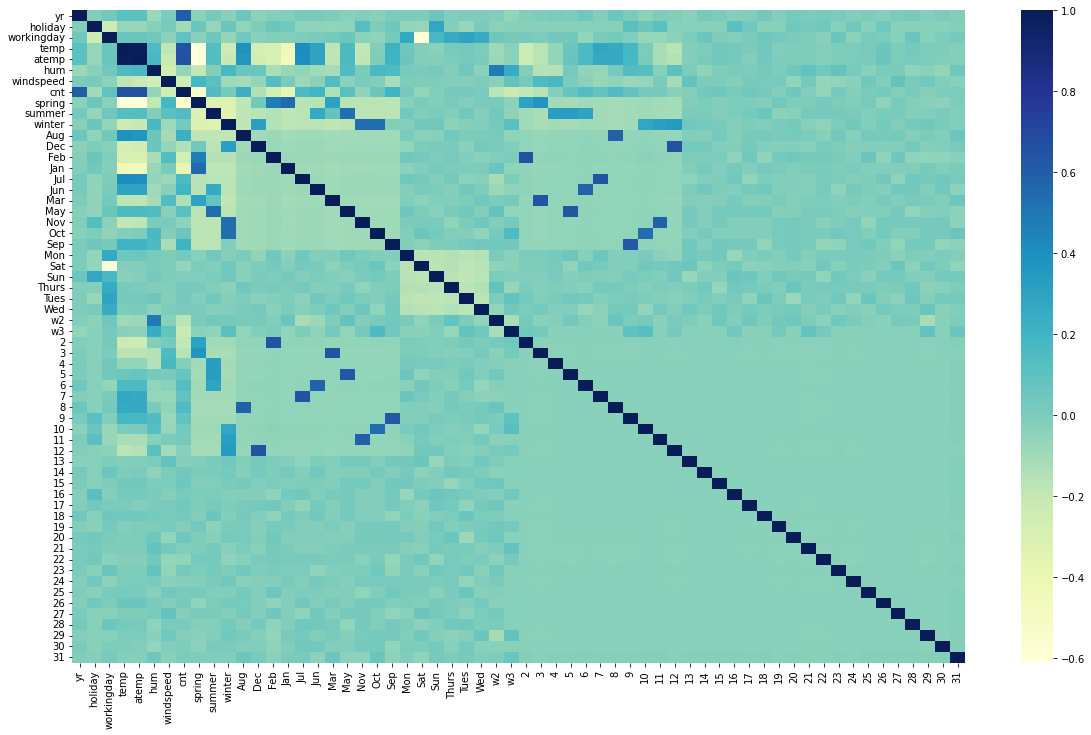

In [26]:
# creating heatmap to visualize correlation between variables
plt.figure(figsize = (20,12))
sns.heatmap(df_train.corr(), cmap='YlGnBu')
plt.show()

#### Observations:
- We can observe some strong correlation between 'cnt' and year from the graph
- A weak correlation is observed for 'cnt' variable with spring
- Lets see if our model also predicts the same way

#### - Dividing Train Set into X and Y sets for the model building

In [27]:
# x_train, y_train

y_train = df_train.pop('cnt')  # will remove cnt from train and store in y_train
X_train = df_train  # remaing of df train is x_train

### Building Model

- Feature Selection:
    - First, I will use automated RFE method to bring down features from 60 to 15
    - then, will use the manual selection of features using p-value to further reduce features
    - Until a decent model is identified.

#### RFE

In [28]:
# Recursive Feature Elimination execution with output variable '15'
lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(lm, n_features_to_select=15)
rfe = rfe.fit(X_train, y_train)

In [29]:
list(zip(X_train.columns, rfe.support_, rfe.ranking_))

[('yr', True, 1),
 ('holiday', True, 1),
 ('workingday', True, 1),
 ('temp', True, 1),
 ('atemp', False, 18),
 ('hum', True, 1),
 ('windspeed', True, 1),
 ('spring', False, 16),
 ('summer', True, 1),
 ('winter', True, 1),
 ('Aug', False, 34),
 ('Dec', False, 11),
 ('Feb', False, 10),
 ('Jan', False, 8),
 ('Jul', False, 17),
 ('Jun', False, 33),
 ('Mar', False, 32),
 ('May', False, 45),
 ('Nov', False, 9),
 ('Oct', False, 31),
 ('Sep', True, 1),
 ('Mon', True, 1),
 ('Sat', False, 6),
 ('Sun', True, 1),
 ('Thurs', True, 1),
 ('Tues', True, 1),
 ('Wed', True, 1),
 ('w2', False, 5),
 ('w3', True, 1),
 (2, False, 30),
 (3, False, 12),
 (4, False, 21),
 (5, False, 27),
 (6, False, 35),
 (7, False, 3),
 (8, False, 41),
 (9, False, 4),
 (10, False, 24),
 (11, False, 7),
 (12, False, 20),
 (13, False, 38),
 (14, False, 37),
 (15, False, 29),
 (16, False, 22),
 (17, False, 23),
 (18, False, 44),
 (19, False, 36),
 (20, False, 26),
 (21, False, 28),
 (22, False, 14),
 (23, False, 25),
 (24, False

In [30]:
# feature list selected by RFE
col = X_train.columns[rfe.support_]
col

Index(['yr', 'holiday', 'workingday', 'temp', 'hum', 'windspeed', 'summer',
       'winter', 'Sep', 'Mon', 'Sun', 'Thurs', 'Tues', 'Wed', 'w3'],
      dtype='object')

In [31]:
# Also, checking the list of features deselected by RFE
X_train.columns[~rfe.support_]

Index([ 'atemp', 'spring',    'Aug',    'Dec',    'Feb',    'Jan',    'Jul',
          'Jun',    'Mar',    'May',    'Nov',    'Oct',    'Sat',     'w2',
              2,        3,        4,        5,        6,        7,        8,
              9,       10,       11,       12,       13,       14,       15,
             16,       17,       18,       19,       20,       21,       22,
             23,       24,       25,       26,       27,       28,       29,
             30,       31],
      dtype='object')

#### Using Statsmodel to Build Model

- Now building a model using Statsmodel to check and verify if all the features selected by RFE are significant using summary statistics

In [32]:
# Creating new X_train set with rfe selected variables
X_train_new = X_train[col]

# Adding const to X_train_rfe set
X_train_rfe = sm.add_constant(X_train_new)

In [33]:
#Running linear model
lr = sm.OLS(y_train, X_train_rfe).fit()

# lets check summary of model
lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.831
Model:                            OLS   Adj. R-squared:                  0.827
Method:                 Least Squares   F-statistic:                     174.4
Date:                Wed, 14 Sep 2022   Prob (F-statistic):          4.91e-181
Time:                        14:59:03   Log-Likelihood:                 492.90
No. Observations:                 510   AIC:                            -955.8
Df Residuals:                     495   BIC:                            -892.3
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2572      0.027      9.543      0.000       0.204       0.310
yr             0.2269      0.008     27.028      0.000       0.210       0.243
holiday       -0.0674      0.024     -2.829      0.005      -0.114      -0.021
workingday     0.0234      0.008      2.927      0.004       0.008       0.039
temp           0.5921      0.020     29.378      0.000       0.552       0.632
hum           -0.2779      0.032     -8.735      0.000      -0.340      -0.215
windspeed     -0.2014      0.026     -7.666      0.000      -0.253      -0.150
summer         0.0891      0.010      8.501      0.000       0.069       0.110
winter         0.1446      0.011     13.493      0.000       0.124       0.166
Sep            0.1042      0.016      6.482      0.000       0.073       0.136
Mon           -0.0158      0.011     -1.375      0.170      -0.038       0.007
Sun           -0.0170      0.010     -1.704      0.089      -0.037       0.003
Thurs         -0.0018      0.011     -0.160      0.873      -0.024       0.021
Tues          -0.0033      0.011     -0.311      0.756      -0.025       0.018
Wed           -0.0060      0.011     -0.539      0.590      -0.028       0.016
w3            -0.1967      0.026     -7.593      0.000      -0.248      -0.146
==============================================================================
Omnibus:                       57.957   Durbin-Watson:                   2.066
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              108.885
Skew:                          -0.681   Prob(JB):                     2.27e-24
Kurtosis:                       4.809   Cond. No.                     6.46e+15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.5e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [34]:
# let us also check VIF
# create a dataframe that will contain the names of all the feature variables and their respective VIF
vif = pd.DataFrame()
X = X_train_new
vif['Features'] = X.columns

vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = 'VIF', ascending = False)
vif

,Features,VIF
1,holiday,inf
2,workingday,inf
9,Mon,inf
10,Sun,inf
11,Thurs,inf
12,Tues,inf
13,Wed,inf
4,hum,10.96
3,temp,7.20
5,windspeed,3.59


##### High P-value, High VIF  - Thurs
- 'Thurs' is insignificant in presence of other variables with high p-value
- VIF - infinite value indicates 'Thurs' variable highly correlated with the other variables

In [35]:
# drop the variable
X_train_new = X_train_new.drop(['Thurs'], axis = 1)

# Adding constant
X_train_lm = sm.add_constant(X_train_new)

In [36]:
# rebuilding the model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.831
Model:                            OLS   Adj. R-squared:                  0.827
Method:                 Least Squares   F-statistic:                     174.4
Date:                Wed, 14 Sep 2022   Prob (F-statistic):          4.91e-181
Time:                        14:59:20   Log-Likelihood:                 492.90
No. Observations:                 510   AIC:                            -955.8
Df Residuals:                     495   BIC:                            -892.3
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2572      0.027      9.543      0.000       0.204       0.310
yr             0.2269      0.008     27.028      0.000       0.210       0.243
holiday       -0.0692      0.030     -2.271      0.024      -0.129      -0.009
workingday     0.0216      0.014      1.551      0.121      -0.006       0.049
temp           0.5921      0.020     29.378      0.000       0.552       0.632
hum           -0.2779      0.032     -8.735      0.000      -0.340      -0.215
windspeed     -0.2014      0.026     -7.666      0.000      -0.253      -0.150
summer         0.0891      0.010      8.501      0.000       0.069       0.110
winter         0.1446      0.011     13.493      0.000       0.124       0.166
Sep            0.1042      0.016      6.482      0.000       0.073       0.136
Mon           -0.0139      0.016     -0.856      0.392      -0.046       0.018
Sun           -0.0152      0.016     -0.943      0.346      -0.047       0.016
Tues          -0.0015      0.016     -0.097      0.923      -0.032       0.029
Wed           -0.0042      0.016     -0.257      0.798      -0.036       0.028
w3            -0.1967      0.026     -7.593      0.000      -0.248      -0.146
==============================================================================
Omnibus:                       57.957   Durbin-Watson:                   2.066
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              108.885
Skew:                          -0.681   Prob(JB):                     2.27e-24
Kurtosis:                       4.809   Cond. No.                         17.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [37]:
# let us also check VIF
# create a dataframe that will contain the names of all the feature variables and their respective VIF
vif = pd.DataFrame()
X = X_train_new
vif['Features'] = X.columns

vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = 'VIF', ascending = False)
vif

,Features,VIF
4,hum,10.96
2,workingday,7.44
3,temp,7.20
5,windspeed,3.59
10,Sun,2.29
11,Tues,2.27
12,Wed,2.06
9,Mon,2.04
0,yr,2.03
7,winter,1.64


##### Tues - High p, Low VIF
- High P-value of 'Tues' defines insignificance of variables, hence needs to be removed

In [38]:
#dropping
X_train_new = X_train_new.drop(['Tues'], axis = 1)

# Adding constant
X_train_lm = sm.add_constant(X_train_new)

# rebuilding the model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.831
Model:                            OLS   Adj. R-squared:                  0.827
Method:                 Least Squares   F-statistic:                     188.2
Date:                Wed, 14 Sep 2022   Prob (F-statistic):          3.52e-182
Time:                        14:59:28   Log-Likelihood:                 492.90
No. Observations:                 510   AIC:                            -957.8
Df Residuals:                     496   BIC:                            -898.5
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2573      0.027      9.555      0.000       0.204       0.310
yr             0.2269      0.008     27.056      0.000       0.210       0.243
holiday       -0.0700      0.029     -2.383      0.018      -0.128      -0.012
workingday     0.0207      0.011      1.908      0.057      -0.001       0.042
temp           0.5921      0.020     29.407      0.000       0.553       0.632
hum           -0.2780      0.032     -8.745      0.000      -0.340      -0.216
windspeed     -0.2014      0.026     -7.673      0.000      -0.253      -0.150
summer         0.0891      0.010      8.514      0.000       0.069       0.110
winter         0.1446      0.011     13.506      0.000       0.124       0.166
Sep            0.1042      0.016      6.488      0.000       0.073       0.136
Mon           -0.0131      0.014     -0.950      0.342      -0.040       0.014
Sun           -0.0144      0.014     -1.056      0.292      -0.041       0.012
Wed           -0.0033      0.014     -0.243      0.808      -0.030       0.024
w3            -0.1969      0.026     -7.641      0.000      -0.248      -0.146
==============================================================================
Omnibus:                       57.830   Durbin-Watson:                   2.066
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              108.623
Skew:                          -0.679   Prob(JB):                     2.59e-24
Kurtosis:                       4.807   Cond. No.                         17.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [39]:
# let us also check VIF
# create a dataframe that will contain the names of all the feature variables and their respective VIF
vif = pd.DataFrame()
X = X_train_new
vif['Features'] = X.columns

vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = 'VIF', ascending = False)
vif

,Features,VIF
4,hum,10.96
3,temp,7.20
2,workingday,4.50
5,windspeed,3.59
0,yr,2.03
7,winter,1.64
10,Sun,1.64
6,summer,1.58
11,Wed,1.47
9,Mon,1.46


##### 'Wed' is insignificant in presence of other variables with high p-value , so dropping

In [40]:
X_train_new = X_train_new.drop(['Wed'], axis = 1)

# Adding constant
X_train_lm = sm.add_constant(X_train_new)

# rebuilding the model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.831
Model:                            OLS   Adj. R-squared:                  0.827
Method:                 Least Squares   F-statistic:                     204.2
Date:                Wed, 14 Sep 2022   Prob (F-statistic):          2.48e-183
Time:                        14:59:34   Log-Likelihood:                 492.87
No. Observations:                 510   AIC:                            -959.7
Df Residuals:                     497   BIC:                            -904.7
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2570      0.027      9.561      0.000       0.204       0.310
yr             0.2269      0.008     27.082      0.000       0.210       0.243
holiday       -0.0713      0.029     -2.474      0.014      -0.128      -0.015
workingday     0.0197      0.010      1.978      0.048       0.000       0.039
temp           0.5921      0.020     29.436      0.000       0.553       0.632
hum           -0.2776      0.032     -8.752      0.000      -0.340      -0.215
windspeed     -0.2014      0.026     -7.680      0.000      -0.253      -0.150
summer         0.0891      0.010      8.526      0.000       0.069       0.110
winter         0.1446      0.011     13.517      0.000       0.124       0.166
Sep            0.1041      0.016      6.491      0.000       0.073       0.136
Mon           -0.0121      0.013     -0.922      0.357      -0.038       0.014
Sun           -0.0133      0.013     -1.034      0.301      -0.039       0.012
w3            -0.1971      0.026     -7.658      0.000      -0.248      -0.147
==============================================================================
Omnibus:                       57.905   Durbin-Watson:                   2.064
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              108.717
Skew:                          -0.680   Prob(JB):                     2.47e-24
Kurtosis:                       4.807   Cond. No.                         17.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [41]:
# let us also check VIF
# create a dataframe that will contain the names of all the feature variables and their respective VIF
vif = pd.DataFrame()
X = X_train_new
vif['Features'] = X.columns

vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = 'VIF', ascending = False)
vif

,Features,VIF
4,hum,10.95
3,temp,7.20
2,workingday,3.73
5,windspeed,3.58
0,yr,2.03
7,winter,1.64
6,summer,1.58
10,Sun,1.46
9,Mon,1.32
1,holiday,1.23


##### 'Mon' is insignificant in presence of other variables with high p-value , so dropping

In [42]:
X_train_new = X_train_new.drop(['Mon'], axis = 1)

# Adding constant
X_train_lm = sm.add_constant(X_train_new)

# rebuilding the model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.831
Model:                            OLS   Adj. R-squared:                  0.827
Method:                 Least Squares   F-statistic:                     222.8
Date:                Wed, 14 Sep 2022   Prob (F-statistic):          2.48e-184
Time:                        14:59:50   Log-Likelihood:                 492.43
No. Observations:                 510   AIC:                            -960.9
Df Residuals:                     498   BIC:                            -910.0
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2579      0.027      9.601      0.000       0.205       0.311
yr             0.2269      0.008     27.086      0.000       0.210       0.243
holiday       -0.0735      0.029     -2.560      0.011      -0.130      -0.017
workingday     0.0168      0.009      1.778      0.076      -0.002       0.035
temp           0.5916      0.020     29.426      0.000       0.552       0.631
hum           -0.2782      0.032     -8.774      0.000      -0.340      -0.216
windspeed     -0.2019      0.026     -7.701      0.000      -0.253      -0.150
summer         0.0890      0.010      8.512      0.000       0.068       0.109
winter         0.1444      0.011     13.504      0.000       0.123       0.165
Sep            0.1044      0.016      6.514      0.000       0.073       0.136
Sun           -0.0105      0.012     -0.840      0.401      -0.035       0.014
w3            -0.1960      0.026     -7.624      0.000      -0.246      -0.145
==============================================================================
Omnibus:                       57.412   Durbin-Watson:                   2.059
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              108.902
Skew:                          -0.672   Prob(JB):                     2.25e-24
Kurtosis:                       4.822   Cond. No.                         17.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [43]:
# let us also check VIF
# create a dataframe that will contain the names of all the feature variables and their respective VIF
vif = pd.DataFrame()
X = X_train_new
vif['Features'] = X.columns

vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = 'VIF', ascending = False)
vif

,Features,VIF
4,hum,10.94
3,temp,7.20
5,windspeed,3.58
2,workingday,3.36
0,yr,2.03
7,winter,1.64
6,summer,1.58
9,Sun,1.38
1,holiday,1.22
8,Sep,1.20


##### 'Sun' is insignificant in presence of other variables with high p-value , so dropping

In [44]:
X_train_new = X_train_new.drop(['Sun'], axis = 1)

# Adding constant
X_train_lm = sm.add_constant(X_train_new)

# rebuilding the model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.831
Model:                            OLS   Adj. R-squared:                  0.827
Method:                 Least Squares   F-statistic:                     245.2
Date:                Wed, 14 Sep 2022   Prob (F-statistic):          2.19e-185
Time:                        14:59:58   Log-Likelihood:                 492.07
No. Observations:                 510   AIC:                            -962.1
Df Residuals:                     499   BIC:                            -915.6
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2585      0.027      9.632      0.000       0.206       0.311
yr             0.2265      0.008     27.093      0.000       0.210       0.243
holiday       -0.0816      0.027     -3.015      0.003      -0.135      -0.028
workingday     0.0147      0.009      1.617      0.107      -0.003       0.033
temp           0.5921      0.020     29.472      0.000       0.553       0.632
hum           -0.2791      0.032     -8.810      0.000      -0.341      -0.217
windspeed     -0.2019      0.026     -7.706      0.000      -0.253      -0.150
summer         0.0888      0.010      8.500      0.000       0.068       0.109
winter         0.1441      0.011     13.488      0.000       0.123       0.165
Sep            0.1047      0.016      6.532      0.000       0.073       0.136
w3            -0.1957      0.026     -7.615      0.000      -0.246      -0.145
==============================================================================
Omnibus:                       56.679   Durbin-Watson:                   2.062
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              107.979
Skew:                          -0.663   Prob(JB):                     3.57e-24
Kurtosis:                       4.824   Cond. No.                         16.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [45]:
# let us also check VIF
# create a dataframe that will contain the names of all the feature variables and their respective VIF
vif = pd.DataFrame()
X = X_train_new
vif['Features'] = X.columns

vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = 'VIF', ascending = False)
vif

,Features,VIF
4,hum,10.94
3,temp,7.19
5,windspeed,3.58
2,workingday,3.13
0,yr,2.02
7,winter,1.64
6,summer,1.58
8,Sep,1.20
9,w3,1.09
1,holiday,1.08


##### 'workingday' is insignificant in presence of other variables with high p-value , so dropping

In [46]:
X_train_new = X_train_new.drop(['workingday'], axis = 1)

# Adding constant
X_train_lm = sm.add_constant(X_train_new)

# rebuilding the model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.830
Model:                            OLS   Adj. R-squared:                  0.827
Method:                 Least Squares   F-statistic:                     271.2
Date:                Wed, 14 Sep 2022   Prob (F-statistic):          4.74e-186
Time:                        15:00:03   Log-Likelihood:                 490.74
No. Observations:                 510   AIC:                            -961.5
Df Residuals:                     500   BIC:                            -919.1
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2682      0.026     10.234      0.000       0.217       0.320
yr             0.2268      0.008     27.103      0.000       0.210       0.243
holiday       -0.0915      0.026     -3.467      0.001      -0.143      -0.040
temp           0.5928      0.020     29.471      0.000       0.553       0.632
hum           -0.2784      0.032     -8.776      0.000      -0.341      -0.216
windspeed     -0.2034      0.026     -7.755      0.000      -0.255      -0.152
summer         0.0892      0.010      8.523      0.000       0.069       0.110
winter         0.1434      0.011     13.413      0.000       0.122       0.164
Sep            0.1052      0.016      6.554      0.000       0.074       0.137
w3            -0.1948      0.026     -7.570      0.000      -0.245      -0.144
==============================================================================
Omnibus:                       60.303   Durbin-Watson:                   2.059
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              109.427
Skew:                          -0.717   Prob(JB):                     1.73e-24
Kurtosis:                       4.759   Cond. No.                         15.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# VIF

In [47]:
# create a dataframe that will contain the names of all the feature variables and their respective 
vif = pd.DataFrame()
X = X_train_new
vif['Features'] = X.columns

vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = 'VIF', ascending = False)
vif

,Features,VIF
3,hum,10.02
2,temp,7.11
4,windspeed,3.54
0,yr,2.01
6,winter,1.64
5,summer,1.58
7,Sep,1.20
8,w3,1.09
1,holiday,1.04


##### Let us drop 'hum' with High VIF

In [48]:
X_train_new = X_train_new.drop(['hum'], axis = 1)

# Adding constant
X_train_lm = sm.add_constant(X_train_new)

# rebuilding the model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.804
Model:                            OLS   Adj. R-squared:                  0.801
Method:                 Least Squares   F-statistic:                     256.6
Date:                Wed, 14 Sep 2022   Prob (F-statistic):          9.22e-172
Time:                        15:00:10   Log-Likelihood:                 454.20
No. Observations:                 510   AIC:                            -890.4
Df Residuals:                     501   BIC:                            -852.3
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0875      0.017      5.029      0.000       0.053       0.122
yr             0.2334      0.009     26.093      0.000       0.216       0.251
holiday       -0.0867      0.028     -3.060      0.002      -0.142      -0.031
temp           0.5682      0.021     26.580      0.000       0.526       0.610
windspeed     -0.1455      0.027     -5.340      0.000      -0.199      -0.092
summer         0.0812      0.011      7.256      0.000       0.059       0.103
winter         0.1261      0.011     11.179      0.000       0.104       0.148
Sep            0.0895      0.017      5.229      0.000       0.056       0.123
w3            -0.2535      0.027     -9.506      0.000      -0.306      -0.201
==============================================================================
Omnibus:                       62.269   Durbin-Watson:                   2.021
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              106.317
Skew:                          -0.761   Prob(JB):                     8.20e-24
Kurtosis:                       4.640   Cond. No.                         9.78
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [49]:
# create a dataframe that will contain the names of all the feature variables and their respective 
vif = pd.DataFrame()
X = X_train_new
vif['Features'] = X.columns

vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = 'VIF', ascending = False)
vif

,Features,VIF
2,temp,3.63
3,windspeed,2.97
0,yr,2.00
4,summer,1.55
5,winter,1.34
6,Sep,1.20
7,w3,1.06
1,holiday,1.03


#### Observations:

- The model seems good with R-squared value of 80% and also no insignificant variables.
- However, from business perspective variable sep positive significance on count is not explainable.
- Let us drop this var and see how the model changes.

In [50]:
X_train_new = X_train_new.drop(['Sep'], axis = 1)

# Adding constant
X_train_lm = sm.add_constant(X_train_new)

# rebuilding the model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.793
Model:                            OLS   Adj. R-squared:                  0.790
Method:                 Least Squares   F-statistic:                     274.9
Date:                Wed, 14 Sep 2022   Prob (F-statistic):          3.11e-167
Time:                        15:00:20   Log-Likelihood:                 440.65
No. Observations:                 510   AIC:                            -865.3
Df Residuals:                     502   BIC:                            -831.4
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0889      0.018      4.978      0.000       0.054       0.124
yr             0.2327      0.009     25.359      0.000       0.215       0.251
holiday       -0.0790      0.029     -2.721      0.007      -0.136      -0.022
temp           0.5914      0.021     27.562      0.000       0.549       0.634
windspeed     -0.1554      0.028     -5.572      0.000      -0.210      -0.101
summer         0.0699      0.011      6.209      0.000       0.048       0.092
winter         0.1233      0.012     10.672      0.000       0.101       0.146
w3            -0.2471      0.027     -9.041      0.000      -0.301      -0.193
==============================================================================
Omnibus:                       53.309   Durbin-Watson:                   1.962
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              103.481
Skew:                          -0.621   Prob(JB):                     3.38e-23
Kurtosis:                       4.823   Cond. No.                         9.76
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

- With removal of Sep variable, there is no significance change in R-squared value from 80 to 79%
- Model seems pretty good with 79% adjusted R-squared

In [51]:
# create a dataframe that will contain the names of all the feature variables and their respective 
vif = pd.DataFrame()
X = X_train_new
vif['Features'] = X.columns

vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = 'VIF', ascending = False)
vif

,Features,VIF
2,temp,3.25
3,windspeed,2.95
0,yr,2.00
4,summer,1.49
5,winter,1.34
6,w3,1.06
1,holiday,1.03


#### Notes:
- All variables now are significant with p-value < 0.05
- All features are not correlated with other features as VIF < 5 for all the features.


## Step 5 - Residual Analysis

In [52]:
y_train_cnt = lr.predict(X_train_lm)

Text(0.5, 0, 'Errors')

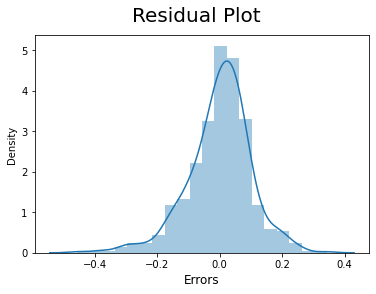

In [53]:
# Residual 
res = y_train - y_train_cnt

fig = plt.figure()
sns.distplot(res, bins = 20)
fig.suptitle('Residual Plot', fontsize = 20)
plt.xlabel('Errors', fontsize = 12)

#### Observations:

- Residuals are normally distributed and are centered around 'zero'
- A slight peak near -0.3 


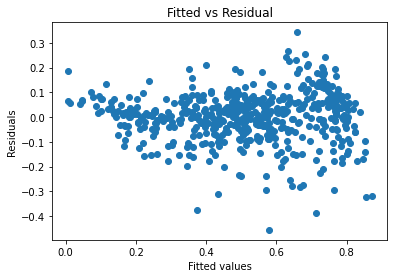

In [54]:
# scatter plot between residuals and fitted values to check if there is significant variance in terms.

plt.scatter(y_train_cnt, res)
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Fitted vs Residual')
plt.show()

## Step 6 - Predictions

#### Transform the test set

In [55]:
# list of numeric variables
num_vars = ['temp','atemp','hum','windspeed','cnt']

# 2. Fit on Data
df_test[num_vars] = scaler.transform(df_test[num_vars])
df_test.head()

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,spring,summer,...,22,23,24,25,26,27,28,29,30,31
184,0,1,0,0.831783,0.769660,0.657364,0.084219,0.692706,0,0,...,0,0,0,0,0,0,0,0,0,0
535,1,0,1,0.901354,0.842587,0.610133,0.153728,0.712034,0,1,...,0,0,0,0,0,0,0,0,0,0
299,0,0,1,0.511964,0.496145,0.837699,0.334206,0.303382,0,0,...,0,0,0,0,0,1,0,0,0,0
221,0,0,1,0.881625,0.795343,0.437098,0.339570,0.547400,0,0,...,0,0,0,0,0,0,0,0,0,0
152,0,0,1,0.817246,0.741471,0.314298,0.537414,0.569029,0,1,...,0,0,0,0,0,0,0,0,0,0


#### Divide into X_test and y_test

In [56]:
y_test = df_test.pop('cnt')
X_test = df_test

X_test.head()

,yr,holiday,workingday,temp,atemp,hum,windspeed,spring,summer,winter,...,22,23,24,25,26,27,28,29,30,31
184,0,1,0,0.831783,0.769660,0.657364,0.084219,0,0,0,...,0,0,0,0,0,0,0,0,0,0
535,1,0,1,0.901354,0.842587,0.610133,0.153728,0,1,0,...,0,0,0,0,0,0,0,0,0,0
299,0,0,1,0.511964,0.496145,0.837699,0.334206,0,0,1,...,0,0,0,0,0,1,0,0,0,0
221,0,0,1,0.881625,0.795343,0.437098,0.339570,0,0,0,...,0,0,0,0,0,0,0,0,0,0
152,0,0,1,0.817246,0.741471,0.314298,0.537414,0,1,0,...,0,0,0,0,0,0,0,0,0,0


#### Predictions on Test Data Using Trained Model

In [57]:
# Matching the columns of train and test predictors
X_test_new = X_test[X_train_new.columns]
X_test_new.head()

,yr,holiday,temp,windspeed,summer,winter,w3
184,0,1,0.831783,0.084219,0,0,0
535,1,0,0.901354,0.153728,1,0,0
299,0,0,0.511964,0.334206,0,1,0
221,0,0,0.881625,0.339570,0,0,0
152,0,0,0.817246,0.537414,1,0,0


In [58]:
# adding the constant variable
X_test_new = sm.add_constant(X_test_new)

In [59]:
# Making predictions
y_test_cnt = lr.predict(X_test_new)

## Step 7 - Model Evaluation

Text(0, 0.5, 'y_test_cnt')

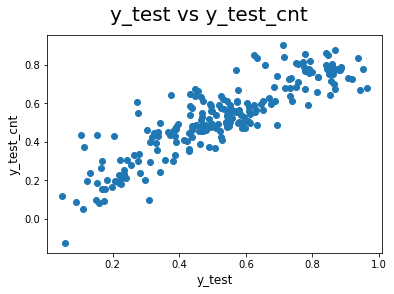

In [60]:
# plotting y_test and y_test_cnt on Graph
fig = plt.figure()
plt.scatter(y_test, y_test_cnt)
fig.suptitle('y_test vs y_test_cnt', fontsize = 20)
plt.xlabel('y_test', fontsize = 12)
plt.ylabel('y_test_cnt', fontsize = 12)

In [61]:
# evaluating using R squared
r2_score(y_true = y_test, y_pred = y_test_cnt)

0.7663190369969771

### Intepretations:

- As per the model analysis, temperature is the driving factor for the increase in shared bikes
- Also, year is the another driving factor of shared bikes
- In the given two years given in data set, the shared bikes count increased by 23%
- Weather situation has negative effect on shared bikes count.
- Extreme weather conditions, can reduce the shared bikes by 25%

-

- Final regression formula for shared bikes count 

cnt = (0.2327 × yr) + (-0.079 × holiday) + (0.5914 × temp) + (-0.1554 × windspeed) + (0.0699 × summer) + (0.1233 × winter) +  (-0.2471 × stormyweather) + 0.0889

- With 1 unit change in temp, bike rentals count increase by 0.594 units
- With every year, count of bike rentals increases by .233
- Stormy weather also reduces the count of bike rents by 0.25
- During holidays, bike rentals decrease by .079
- Windspeed has negative impact on bike rentals by 0.155 units

